In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import resnet50
from torchvision import transforms
from torchvision import models

from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
import json
import os

In [3]:
class MPIIDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_folder, 'mpii_human_pose_v1/images', self.data[idx]['img_paths'])
        image = Image.open(img_path).convert('RGB')
        joints = torch.tensor(self.data[idx]['joint_self'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, joints

    def load_data(self):
        json_path = os.path.join(self.data_folder, 'mpii_annotations.json')
        with open(json_path, 'r') as f:
            data = json.load(f)
            
        for entry in data:
            img_width = entry["img_width"]
            img_height = entry["img_height"]

            for temp in entry["joint_self"]:
                temp[0] = temp[0] / img_width
                temp[1] = temp[1] / img_height

            entry["objpos"] = (
                entry["objpos"][0] / img_width,
                entry["objpos"][1] / img_height
            )

            entry["img_width"] = 256
            entry["img_height"] = 256

        return data

In [4]:
# Define your own transformation if needed
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
# Provide the path to your dataset folder
data_folder = '/kaggle/input/mpii-human-pose/'

# Create dataset and data loader
mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=64, shuffle=True, num_workers=4)

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Load the pre-trained weights of MobileNetV2 and freeze the weights
        self.backbone = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Initialize num_keypoints as a class attribute
        self.num_keypoints = 16

        # Modify the last layer of the backbone
        self.backbone.classifier[1] = nn.Sequential(
            nn.Conv2d(self.backbone.last_channel, self.num_keypoints * 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.num_keypoints * 3, self.num_keypoints * 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU6()
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1, 1, 1)
        x = self.backbone.classifier.to(x.device)(x)
        x = x.view(x.size(0), self.num_keypoints, 3)
        x = F.relu6(x) / 6.0
        return x

In [7]:
# Instantiate your model, loss function, and optimizer
model = MyModel()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.9, momentum=0.0, centered=False)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 30

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 59.9MB/s]


In [ ]:
print(model)

In [8]:
for epoch in range(num_epochs):
    model.train()

    for batch_idx, (images, joints) in enumerate(mpi_dataloader):
        images, joints = images.cuda(), joints.cuda()
        optimizer.zero_grad()
        outputs = model(images).to(device)

        loss = criterion(outputs, joints)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch {epoch + 1} in {num_epochs}, Batch {batch_idx + 1}/{len(mpi_dataloader)}, Loss: {loss.item()}')

print("Training finished!")

Epoch 1 in 30, Batch 10/394, Loss: 0.23919591307640076
Epoch 1 in 30, Batch 20/394, Loss: 0.1656375229358673
Epoch 1 in 30, Batch 30/394, Loss: 0.1518806517124176
Epoch 1 in 30, Batch 40/394, Loss: 0.14947271347045898
Epoch 1 in 30, Batch 50/394, Loss: 0.13756412267684937
Epoch 1 in 30, Batch 60/394, Loss: 0.15621334314346313
Epoch 1 in 30, Batch 70/394, Loss: 0.14099127054214478
Epoch 1 in 30, Batch 80/394, Loss: 0.14260689914226532
Epoch 1 in 30, Batch 90/394, Loss: 0.1471119225025177
Epoch 1 in 30, Batch 100/394, Loss: 0.13840126991271973
Epoch 1 in 30, Batch 110/394, Loss: 0.13153855502605438
Epoch 1 in 30, Batch 120/394, Loss: 0.13422033190727234
Epoch 1 in 30, Batch 130/394, Loss: 0.1400635540485382
Epoch 1 in 30, Batch 140/394, Loss: 0.12825550138950348
Epoch 1 in 30, Batch 150/394, Loss: 0.13435839116573334
Epoch 1 in 30, Batch 160/394, Loss: 0.13833898305892944
Epoch 1 in 30, Batch 170/394, Loss: 0.13597452640533447
Epoch 1 in 30, Batch 180/394, Loss: 0.13375525176525116
Epoch

In [17]:
def visualize_batch_predictions(images, keypoints, predicted_keypoints, num_images=4, target_size=(256, 256)):
    """
    Visualize a batch of input images with ground truth and predicted keypoints.

    Args:
        images (Tensor): Batch of input image tensors.
        keypoints (Tensor): Batch of ground truth keypoints.
        predicted_keypoints (Tensor): Batch of predicted keypoints.
        num_images (int): Number of images to visualize.
        target_size (tuple): Target size for visualization (height, width).
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    images_resized = torch.stack([transform(image) for image in images[:num_images].cpu()])
    keypoints = keypoints[:num_images].cpu().numpy()
    predicted_keypoints = predicted_keypoints[:num_images].cpu().detach().numpy()

    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        image = images_resized[i].permute(1, 2, 0).numpy()  # Convert image tensor to numpy array and change channel order
        plt.imshow(image)
        plt.scatter(keypoints[i, :, 0] * 256, keypoints[i, :, 1] * 256, s=10, c='r', marker='o', label='Ground Truth')
        plt.scatter(predicted_keypoints[i, :, 0] * 256, predicted_keypoints[i, :, 1] * 256, s=10, c='b', marker='o', label='Predicted')
        plt.title(f'Image {i + 1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

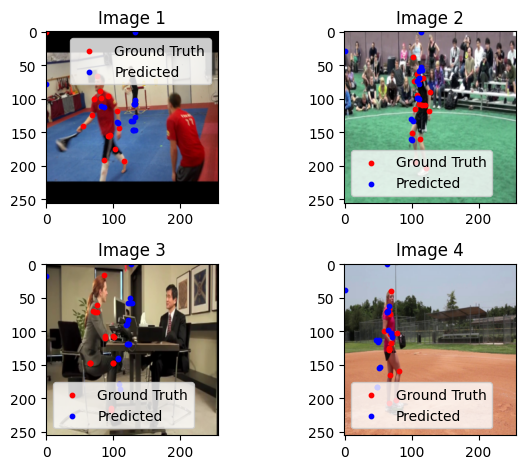

In [20]:
# Example usage:
# Assuming you have a batch of test images and their corresponding ground truth keypoints
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mpi_dataset = MPIIDataset(data_folder, transform=transform)
mpi_dataloader = DataLoader(mpi_dataset, batch_size=64, shuffle=True, num_workers=4)

batch_images, batch_ground_truth_keypoints = next(iter(mpi_dataloader))
batch_images = batch_images.to(device)
batch_ground_truth_keypoints = batch_ground_truth_keypoints.to(device)

# Forward pass to get model predictions
model.eval()
with torch.no_grad():
    batch_predicted_keypoints = model(batch_images)

# Visualize the predictions for the first four images in the batch
visualize_batch_predictions(batch_images, batch_ground_truth_keypoints, batch_predicted_keypoints)

In [10]:
torch.save(model, 'pythorch_test.pth')